In [ ]:
# Creating a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('titanic').getOrCreate()

Exception: Java gateway process exited before sending its port number

In [2]:
spark

### Loading data and exploratory analysis

In [3]:
# Reading data
df = spark.read.csv('./datasets/titanic.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [4]:
df.count()

891

In [5]:
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [6]:
# Counting missing values
from pyspark.sql.functions import col, sum

df.select(*(sum(col(c).isNull().cast('int')).alias(c) for c in df.columns)).toPandas().melt()

,variable,value
0,PassengerId,0
1,Survived,0
2,Pclass,0
3,Name,0
4,Sex,0
5,Age,177
6,SibSp,0
7,Parch,0
8,Ticket,0
9,Fare,0


In [7]:
# Count of unique values
from pyspark.sql.functions import col, countDistinct

df.select(*(countDistinct(col(c)).alias(c) for c in df.columns)).toPandas().melt()

,variable,value
0,PassengerId,891
1,Survived,2
2,Pclass,3
3,Name,891
4,Sex,2
5,Age,88
6,SibSp,7
7,Parch,7
8,Ticket,681
9,Fare,248


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


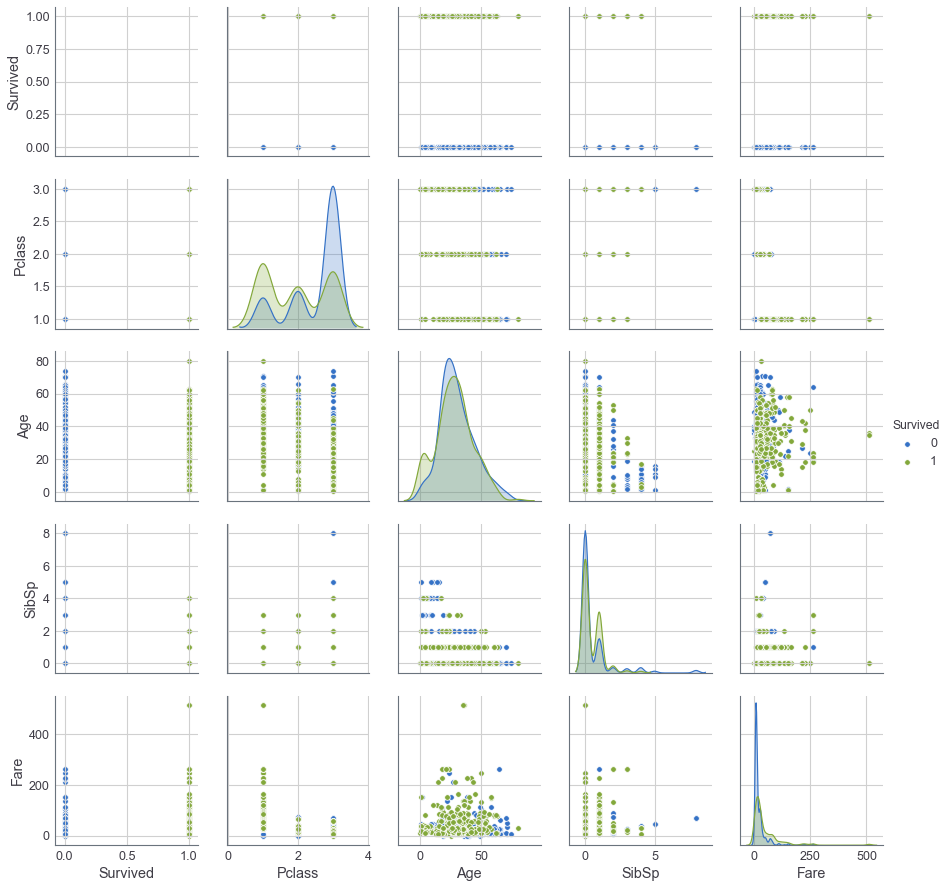

In [9]:
# Exploring correlations
import seaborn as sns

sns.pairplot(df.select('Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked').toPandas(), hue='Survived')

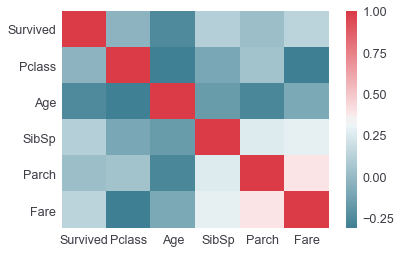

In [10]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

num_columns = [item[0] for item in df.drop('PassengerId').dtypes if not item[1]=='string']
corr_data = VectorAssembler(inputCols=num_columns, outputCol='features').transform(df.dropna()).select('features')

corr_mat = Correlation.corr(corr_data, 'features').toPandas()
corr_mat = pd.DataFrame(corr_mat['pearson(features)'][0].toArray().astype(float),
                        columns=num_columns, 
                        index=num_columns)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, cmap=cmap)

### Missing data imputation

In [10]:
# TODO : otherwise most of the data is discarded

### Transform dataframe with dataframe-mapper (categorical & numerical transformations)

In [4]:
# Installing dev fork of pipeasy-spark
import sys
!{sys.executable} -m pip install --upgrade git+git://github.com/Quantmetry/pipeasy-spark.git@dev#egg=pipeasy-spark

  Cloning git://github.com/Quantmetry/pipeasy-spark.git (to revision dev) to /private/var/folders/sn/cwcnrpx94j78p16ctcj9gqvc0000gn/T/pip-install-lplx8_c9/pipeasy-spark
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
  Running setup.py bdist_wheel for pipeasy-spark ... done
  Stored in directory: /private/var/folders/sn/cwcnrpx94j78p16ctcj9gqvc0000gn/T/pip-ephem-wheel-cache-h3pixtdn/wheels/62/7a/48/4cfcaa2e08144a7f392c8982f378ccc2a67310975d160179f3
Successfully built pipeasy-spark
  Found existing installation: pipeasy-spark 0.1.2
    Uninstalling pipeasy-spark-0.1.2:
      Successfully uninstalled pipeasy-spark-0.1.2


In [5]:
import pipeasy_spark as ppz
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler

df_pipe = df.drop('PassengerId', 'Name', 'Ticket', 'Cabin').dropna()
ppz_pipeline= ppz.map_by_dtypes(df_pipe,
                                target_name='Survived',
                                cat_transformers=[StringIndexer, OneHotEncoderEstimator],
                                num_transformers=[VectorAssembler, StandardScaler])
ppz_model = ppz_pipeline.fit(df_pipe)
df_pipe_out = ppz_model.transform(df_pipe)
df_pipe_out.limit(5).toPandas()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_indexed,Sex_transformed,...,Age_assembled,Age_scaled,SibSp_assembled,SibSp_scaled,Parch_assembled,Parch_scaled,Fare_assembled,Fare_scaled,label,features
0,0,3,male,22.0,1,0,7.2500,S,0.0,(1.0),...,[22.0],[1.5179812223865952],[1.0],[1.0744691732521585],[0.0],[0.0],[7.25],[0.13695098477152595],0.0,"[1.0, 1.0, 0.0, 3.5848533492240673, 1.51798122..."
1,1,1,female,38.0,1,0,71.2833,C,1.0,(0.0),...,[38.0],[2.6219675659404826],[1.0],[1.0744691732521585],[0.0],[0.0],[71.2833],[1.346526639001947],1.0,"[0.0, 0.0, 1.0, 1.1949511164080224, 2.62196756..."
2,1,3,female,26.0,0,0,7.9250,S,1.0,(0.0),...,[26.0],[1.7939778082750673],[0.0],[0.0],[0.0],[0.0],[7.925],[0.1497015936985301],1.0,"(0.0, 1.0, 0.0, 3.5848533492240673, 1.79397780..."
3,1,1,female,35.0,1,0,53.1000,S,1.0,(0.0),...,[35.0],[2.414970126524129],[1.0],[1.0744691732521585],[0.0],[0.0],[53.1],[1.003047902257659],1.0,"[0.0, 1.0, 0.0, 1.1949511164080224, 2.41497012..."
4,0,3,male,35.0,0,0,8.0500,S,0.0,(1.0),...,[35.0],[2.414970126524129],[0.0],[0.0],[0.0],[0.0],[8.05],[0.15206281757390125],0.0,"[1.0, 1.0, 0.0, 3.5848533492240673, 2.41497012..."


In [6]:
# Random split into train/test
train, test = df_pipe.randomSplit([.7,.3], seed=42)
print(train.count())
print(test.count())

503
209


### Training a random forest and defining the full pipeline (with ML)

In [7]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels=ppz_model.stages[14].labels)

# Chain ppz_pipeline, rf and reverse label indexer
pipeline = Pipeline(stages=[ppz_pipeline, rf, labelConverter])

# Train model.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
AUROC = evaluator.evaluate(predictions)
print("Test AUROC = {0}".format(AUROC))

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             1|  0.0|[0.0,1.0,0.0,1.20...|
|             1|  0.0|(8,[2,3,4,7],[1.0...|
|             0|  0.0|[1.0,0.0,1.0,1.20...|
|             0|  0.0|[1.0,1.0,0.0,1.20...|
|             0|  0.0|[1.0,1.0,0.0,1.20...|
+--------------+-----+--------------------+
only showing top 5 rows

Test AUROC = 0.773295985060691


In [8]:
ppz_pipeline.fit(train).transform(train)

DataFrame[Survived: int, Pclass: int, Sex: string, Age: double, SibSp: int, Parch: int, Fare: double, Embarked: string, Sex_indexed: double, Sex_transformed: vector, Embarked_indexed: double, Embarked_transformed: vector, Pclass_assembled: vector, Pclass_scaled: vector, Age_assembled: vector, Age_scaled: vector, SibSp_assembled: vector, SibSp_scaled: vector, Parch_assembled: vector, Parch_scaled: vector, Fare_assembled: vector, Fare_scaled: vector, label: double, features: vector]